#### Interactive Kymograph Code Draft

Xref: Journal/12_26_18/Interactive_Kymograph_Draft_no_scaling.ipynb

Goal: In this notebook, I will finalize the interactive kymograph code I wrote in `Interactive_Kymograph_v1.ipynb` This is a copy of `Interactive_Kymograph_Draft_no_scaling.ipynb`

This code should have the following features:

- seamless parameter tuning with visual outputs
- chunking of the analysis process into steps
- representative results from across the dataset
- global qc stats?

I should also use this code as an oppertunity to try out new things for the main (hdf5 using) codebase.

#### NOTE:

Modifying this code haphazardly is getting a bit unwieldy. Try to write down a game plan for the final drafting of the interactive kymograph, given what I have learned about the implementation. In addition, review the structure of this and the original kymograph code for restructuring/simplification. Finally, move on to the extraction code.

**THIS KYMOGRAPH CODE MUST BE DEPLOYABLE BY 1/4**

### PLAN TO GET THIS DONE

 - (1/2) Implement this structure and finish interactive code (including comments).
 - (1/3) Try to eleminate redundancy in codebase with global handlers for main code differences between interactive and
 server code...
 - (1/3) Revisit original code and implement structural simplification (i.e. distinct stopping points)
 - (1/3) Devise and implement library structure for the hdf5 conversion and kymograph code
 - (1/4) Finishing touches on library and start working on segmentation code.
 - (1/5) Write down structure of segmentation code (try to keep schematically similar to kymo code)
 - (?) Try to figure out if the read/write overhead is causing major problems...eliminate unnecessary I/O
 - (?) Play around with the dask way of chunking (in bookmarks) (don't do this until kymo interactive is done, but before seg)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
import scipy.signal
import shutil
import skimage as sk
from skimage import filters,transform

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

import time
import os
import warnings
matplotlib.rcParams['figure.figsize'] = [20, 10]
warnings.filterwarnings(action='once')

In [2]:
list(range(0,3,2))

[0, 2]

In [7]:
class kymograph_interactive:
    def __init__(self,input_file_prefix,all_channels,trench_len_y,padding_y,trench_width_x,\
                 fov_list,t_subsample_step=1,y_percentile=85,y_min_edge_dist=50,smoothing_kernel_y=(9,3),\
                 triangle_nbins=50,triangle_scaling=1.,x_percentile=85,background_kernel_x=(301,1),smoothing_kernel_x=(9,1),\
                 otsu_nbins=50,otsu_scaling=1.):
        """The kymograph class is used to generate and visualize kymographs. The central function of this
        class is the method 'generate_kymograph', which takes an hdf5 file of images from a single fov and
        outputs an hdf5 file containing kymographs from all detected trenches.

        NOTE: I need to revisit the row detection, must ensure there can be no overlap...
            
        Args:
            input_file_prefix (string): File prefix for all input hdf5 files of the form
            [input_file_prefix][number].hdf5 
            all_channels (list): list of strings corresponding to the different image channels
            available in the input hdf5 file, with the channel used for segmenting trenches in
            the first position. NOTE: these names must match those of the input hdf5 file datasets.
            trench_len_y (int): Length from the end of the tenches to be used when cropping in the 
            y-dimension.
            padding_y (int): Padding to be used when cropping in the y-dimension.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
            fov_list (list): List of ints corresponding to fovs of interest.

            t_subsample_step(int): Step size to be used for subsampling input files in time.

            y_percentile (int): Used for reducing signal in xyt to only the yt dimension when cropping
            in the y-dimension.
            y_min_edge_dist (int): Used when detecting present rows, filters for a minimum row size along the y dimension.
            smoothing_kernel_y (tuple): Two-entry tuple specifying a kernel size for smoothing out yt
            signal when cropping in the y-dimension.
            triangle_nbins (int): Number of bins to use when applying the triangle method to y-dimension signal.
            triangle_scaling (float): Threshold scaling factor for triangle method thresholding.

            x_percentile (int): Used for reducing signal in xyt to only the xt dimension when cropping
            in the x-dimension.
            background_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing background subtraction
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
            smoothing_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing smoothing
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
            otsu_nbins (int): Number of bins to use when applying Otsu's method to x-dimension signal.
            otsu_scaling (float): Threshold scaling factor for Otsu's method thresholding.
        """
        
        self.input_file_prefix = input_file_prefix        
        
        self.all_channels = all_channels
        self.seg_channel = self.all_channels[0]
        
        #### For prieviewing
        self.fov_list = fov_list
        self.num_fovs = len(fov_list)
        self.t_subsample_step = t_subsample_step
        
        #### important paramaters to set
        self.trench_len_y = trench_len_y
        self.padding_y = padding_y
        self.ttl_len_y = trench_len_y+padding_y
        self.trench_width_x = trench_width_x
        
        #### params for y
        ## parameter for reducing signal to one dim
        self.y_percentile = y_percentile
        self.y_min_edge_dist = y_min_edge_dist
        ## parameters for threshold finding
        self.smoothing_kernel_y = smoothing_kernel_y
        self.triangle_nbins = triangle_nbins
        self.triangle_scaling = triangle_scaling
        

        #### params for x
        ## parameter for reducing signal to one dim
        self.x_percentile = x_percentile
        ## parameters for midpoint finding
        self.background_kernel_x = background_kernel_x
        self.smoothing_kernel_x = smoothing_kernel_x
        ## parameters for threshold finding
        self.otsu_nbins = otsu_nbins
        self.otsu_scaling = otsu_scaling
        
    def writedir(self,directory,overwrite=False):
        """Creates an empty directory at the specified location. If a directory is
        already at this location, it will be overwritten if 'overwrite' is true,
        otherwise it will be left alone. 
        
        Args:
            directory (str): Path to directory to be overwritten/created.
            overwrite (bool, optional): Whether to overwrite a directory that
            already exists in this location.
        """
        print(directory)
        if overwrite:
            if os.path.exists(directory):
                shutil.rmtree(directory)
            os.makedirs(directory)
        else:
            if not os.path.exists(directory):
                os.makedirs(directory)
    
    def removefile(self,filepath):
        """Removes a file at the specified path, if it exists.
        
        Args:
            filepath (str): Path to file for deletion.
        """
        if os.path.exists(filepath):
            os.remove(filepath)
    
    def median_filter_2d(self,array,smoothing_kernel):
        """Two-dimensional median filter, with average smoothing at the signal edges in
        the first dimension.
        
        Args:
            array_list (list): List containing a single array of yt signal to be smoothed.
        
        Returns:
            array: Median-filtered yt signal.
        """
        kernel = np.array(smoothing_kernel)
        kernel_pad = kernel//2 + 1
        med_filter = scipy.signal.medfilt(array,kernel_size=kernel)
        start_edge = np.mean(med_filter[kernel_pad[0]:kernel[0]])
        end_edge = np.mean(med_filter[-kernel[0]:-kernel_pad[0]])
        med_filter[:kernel_pad[0]] = start_edge
        med_filter[-kernel_pad[0]:] = end_edge
        return med_filter
    
    def map_to_fovs(self,func,*args,**kargs):
        """Handler for performing steps of analysis across multiple fovs. Appends output
        of a function to a list of outputs for each fov.
        
        Args:
            func (function): Function to apply to each fov. NOTE: Must be written
            to accept the fov index i as the first argument.
            *args: Arguments to pass to the function.
            **kargs: Keyword arguments to pass to the function.
        
        Returns:
            list: List of function outputs, one for each fov.
        """
        output_list = []
        for i in range(self.num_fovs):
            output = func(i,*args,**kargs)
            output_list.append(output)
        return output_list
        
    def import_hdf5(self,i):
        """Performs initial import of the hdf5 file to be processed. Converts the input hdf5 file's "channel"
        datasets into the first dimension of the array, ordered as specified by 'self.all_channels'. Outputs
        a numpy array.
        
        Args:
            i (int): Specifies the current fov index.
        
        Returns:
            array: A numpy array containing the hdf5 file image data.
        """
        fov = self.fov_list[i]
        hdf5_handle = h5py.File(self.input_file_prefix + str(fov) + ".hdf5", "a")
        t_len = hdf5_handle[self.seg_channel].shape[2]
        indices = list(range(0,t_len,self.t_subsample_step))
        array = np.array([np.take(hdf5_handle[channel], indices, axis=2) for channel in self.all_channels])
        hdf5_handle.close()
        return array
    
    def get_smoothed_y_percentiles(self,i,imported_array_list,y_percentile,smoothing_kernel_y):
        """For each imported array, computes the percentile along the x-axis of the segmentation
        channel, generating a (y,t) array. Then performs median filtering of this array for smoothing.
        
        Args:
            i (int): Specifies the current fov index.
            imported_array_list (list): A list containing numpy arrays containing the hdf5 file image
            data of shape (channel,y,x,t).
            y_percentile (int): Percentile to apply along the x-axis.
            smoothing_kernel_y (tuple): Kernel to use for median filtering.
        
        Returns:
            array: A smoothed percentile array of shape (y,t)
        """
        imported_array = imported_array_list[i]
        y_percentiles = np.percentile(imported_array[0],y_percentile,axis=1)
        y_percentiles_smoothed = self.median_filter_2d(y_percentiles,smoothing_kernel_y)
        return y_percentiles_smoothed
    
    def triangle_threshold(self,img_arr,triangle_nbins,triangle_scaling):
        """Applys a triangle threshold, returning a boolean mask.
        
        Args:
            img_arr (array): Image array to be thresholded.
            triangle_nbins (int): Number of bins to be used to construct the thresholding
            histogram.
            triangle_scaling (float): Factor by which to scale the threshold.
        
        Returns:
            array: Boolean mask produced by the threshold.
        """
        triangle_threshold = sk.filters.threshold_triangle(img_arr,nbins=triangle_nbins)*triangle_scaling
        triangle_mask = img_arr>triangle_threshold
        return triangle_mask
    
    def remove_small_rows(self,edges,min_edge_dist):
        """Filters out small rows when performing automated row detection.
        
        Args:
            edges (array): Array of edges along y-axis.
            min_edge_dist (int): Minimum row length necessary for detection.
        
        Returns:
            array: Array of edges, filtered for rows that are too small.
        """
        grouped_edges = edges.reshape(-1,2)
        row_lens = np.diff(grouped_edges,axis=1)
        row_mask = (row_lens>min_edge_dist).flatten()
        filtered_edges = grouped_edges[row_mask]
        return filtered_edges.flatten()
    
    def get_edges_from_mask(self,mask,min_edge_dist):
        """Finds edges from a boolean mask of shape (y,t). Filters out rows of length
        smaller than min_edge_dist.
        
        Args:
            mask (array): Boolean of shape (y,t) resulting from triangle thresholding.
            min_edge_dist (int): Minimum row length necessary for detection.
        
        Returns:
            list: List containing arrays of edges for each timepoint, filtered for rows that are too small.
        """
        edges_list = []
        for t in range(mask.shape[1]):
            edge_mask = (mask[1:,t] != mask[:-1,t])
            edges = np.where(edge_mask)[0]
            edges = self.remove_small_rows(edges,min_edge_dist)
            edges_list.append(edges)
        return edges_list

    
    def get_trench_edges_y(self,i,y_percentiles_smoothed_list,triangle_nbins,triangle_scaling,min_edge_dist):
        """Detects edges in the shape (y,t) smoothed percentile arrays for each input array.
        
        Args:
            i (int): Specifies the current fov index.
            y_percentiles_smoothed_list (list): List containing a smoothed percentile array for each input array.
            triangle_nbins (int): Number of bins to be used to construct the thresholding histogram.
            triangle_scaling (float): Factor by which to scale the threshold.
            min_edge_dist (int): Minimum row length necessary for detection.
        
        Returns:
            list: List containing arrays of edges for each timepoint, filtered for rows that are too small.
        """
        y_percentiles_smoothed = y_percentiles_smoothed_list[i]
        trench_mask_y = self.triangle_threshold(y_percentiles_smoothed,triangle_nbins,triangle_scaling)
        trench_edges_y_list = self.get_edges_from_mask(trench_mask_y,min_edge_dist)
        return trench_edges_y_list
    
    def get_row_numbers(self,i,trench_edges_y_list):
        """Computes the number of trench rows in the fov, from the detected edges.
        
        Args:
            i (int): Specifies the current fov index.
            trench_edges_y_list (list): List containing, for each fov entry, a list of time-sorted edge arrays.
        
        Returns:
            int: The number of trench rows detected in the fov of index i.
        """
        trench_edges_y = trench_edges_y_list[i]
        edge_num_list = [len(item) for item in trench_edges_y]
        trench_row_num = (np.median(edge_num_list).astype(int))//2
        return trench_row_num

    def crop_y(self,i,trench_edges_y_lists,row_num_list,imported_array_list,padding_y,trench_len_y,top_orientation=0):
        """Performs cropping of the images in the y-dimension.
        
        Args:
            i (int): Specifies the current fov index.
            trench_edges_y_list (list): List containing, for each fov entry, a list of time-sorted edge arrays.
            row_num_list (list): List containing The number of trench rows detected in each fov.
            imported_array_list (list): A list containing numpy arrays containing the hdf5 file image
            data of shape (channel,y,x,t).
            padding_y (int): Padding to be used when cropping in the y-dimension.
            trench_len_y (int): Length from the end of the tenches to be used when cropping in the 
            y-dimension.
            top_orientation (int, optional): The orientation of the top-most row where 0 corresponds to a trench with
            a downward-oriented trench opening and 1 corresponds to a trench with an upward-oriented trench opening.
        Returns:
            array: A y-cropped array of shape (rows,channels,x,y,t).
        """
        trench_edges_y_list = trench_edges_y_lists[i]
        imported_array = imported_array_list[i]
        trench_row_num = row_num_list[i]

        time_list = []
        for t in range(imported_array.shape[3]):
            trench_edges_y = trench_edges_y_list[t]
            orientation = top_orientation

            top_bottom_list = []
            for r in range(0,trench_row_num):
                if orientation == 0:
                    trench_edge_y = trench_edges_y[2*r]
                    upper = max(trench_edge_y-padding_y,0)
                    lower = min(trench_edge_y+trench_len_y,imported_array.shape[1])
                else:
                    trench_edge_y = trench_edges_y[(2*r)+1]
                    upper = max(trench_edge_y-trench_len_y,0)
                    lower = min(trench_edge_y+padding_y,imported_array.shape[1])

                orientation = (orientation+1)%2

                channel_list = []
                for c in range(imported_array.shape[0]):
                    output_array = imported_array[c,upper:lower,:,t]
                    channel_list.append(output_array)
                top_bottom_list.append(channel_list)
            time_list.append(top_bottom_list)

        cropped_in_y = np.array(time_list)
        if len(cropped_in_y.shape) != 5:
            return None
        else:
            cropped_in_y = np.moveaxis(cropped_in_y,(0,1,2,3,4),(4,0,1,2,3))
            return cropped_in_y
        
    def crop_trenches_in_y(self,imported_array_list):
        """Master function for cropping the input hdf5 file in the y-dimension.
        
        Args:
            imported_array_list (list): List containing, for each fov entry, a numpy array containing
            the corresponding hdf5 file image data.
        
        Returns:
            list: List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
        """        
        y_percentiles_smoothed_list = self.map_to_fovs(self.get_smoothed_y_percentiles,imported_array_list,\
                                                       self.y_percentile,self.smoothing_kernel_y)
        
        trench_edges_y_lists = self.map_to_fovs(self.get_trench_edges_y,y_percentiles_smoothed_list,self.triangle_nbins,\
                                               self.triangle_scaling,self.min_edge_dist)
        row_num_list = self.map_to_fovs(self.get_row_numbers,trench_edges_y_lists)
        cropped_in_y_list = self.map_to_fovs(self.crop_y,trench_edges_y_lists,row_num_list,imported_array_list,self.padding_y,\
                                             self.trench_len_y)
        return cropped_in_y_list
    
    def get_smoothed_x_percentiles(self,i,cropped_in_y_list,x_percentile,background_kernel_x,smoothing_kernel_x):
        """Summary
        
        Args:
            i (int): Specifies the current fov index.
            cropped_in_y_list (list): List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
            x_percentile (int): Used for reducing signal in xyt to only the xt dimension when cropping
            in the x-dimension.
            background_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing background subtraction
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
            smoothing_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing smoothing
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
        
        Returns:
            array: A smoothed and background subtracted percentile array of shape (rows,x,t)
        """
        cropped_in_y = cropped_in_y_list[i]
        x_percentiles_smoothed_rows = []
        for row_num in range(cropped_in_y.shape[0]):
            cropped_in_y_arr = cropped_in_y[row_num,0]
            x_percentiles = np.percentile(cropped_in_y_arr,x_percentile,axis=0)
            x_background_filtered = x_percentiles - self.median_filter_2d(x_percentiles,background_kernel_x)
            x_smooth_filtered = self.median_filter_2d(x_background_filtered,smoothing_kernel_x)
            x_percentiles_smoothed_rows.append(x_smooth_filtered)
        x_percentiles_smoothed_rows=np.array(x_percentiles_smoothed_rows)
        return x_percentiles_smoothed_rows
    
    def get_midpoints_from_mask(self,mask):
        """Using a boolean x mask, computes the positions of trench midpoints.
        
        Args:
            mask (array): x boolean array, specifying where trenches are present.
        
        Returns:
            array: array of trench midpoint x positions.
        """
        transitions = mask[:-1].astype(int) - mask[1:].astype(int)
        
        trans_up = np.where((transitions==-1))[0]
        trans_dn = np.where((transitions==1))[0]
                
        if len(np.where(trans_dn>trans_up[0])[0])>0:
            first_dn = np.where(trans_dn>trans_up[0])[0][0]
            trans_dn = trans_dn[first_dn:]
            trans_up = trans_up[:len(trans_dn)]
            midpoints = (trans_dn + trans_up)//2
        else:
            midpoints = []
        return midpoints
    
    def get_midpoints(self,x_percentiles_t,otsu_nbins,otsu_scaling):
        """Given an array of signal in x, determines the position of trench midpoints.
        
        Args:
            x_percentiles_t (array): array of trench intensities in x, at time t.
            otsu_nbins (int): Number of bins to use when applying Otsu's method to x-dimension signal.
            otsu_scaling (float): Threshold scaling factor for Otsu's method thresholding.
        
        Returns:
            array: array of trench midpoint x positions.
        """
        otsu_threshold = sk.filters.threshold_otsu(x_percentiles_t[:,np.newaxis],nbins=otsu_nbins)*otsu_scaling
        x_mask = x_percentiles_t>otsu_threshold
        midpoints = self.get_midpoints_from_mask(x_mask)
        return midpoints
    
    def get_all_midpoints(self,i,x_percentiles_smoothed_list,otsu_nbins,otsu_scaling):
        """Given an x percentile array of shape (rows,x,t), determines the trench midpoints of each row array
        at each time t.
        
        Args:
            i (int): Specifies the current fov index.
            x_percentiles_smoothed (array): A smoothed and background subtracted percentile array of shape (rows,x,t)
            otsu_nbins (TYPE): Description
            otsu_scaling (TYPE): Description
        
        Returns:
            list: A nested list of the form [row_list,[time_list,[midpoint_array]]].
        """
        x_percentiles_smoothed_row = x_percentiles_smoothed_list[i]
        midpoints_row_list = []
        for j in range(x_percentiles_smoothed_row.shape[0]):
            x_percentiles_smoothed = x_percentiles_smoothed_row[j]
            all_midpoints = []
            midpoints = self.get_midpoints(x_percentiles_smoothed[:,0],otsu_nbins,otsu_scaling)
            if len(midpoints) == 0:
                return None
            all_midpoints.append(midpoints)
            for t in range(1,x_percentiles_smoothed.shape[1]):
                midpoints = self.get_midpoints(x_percentiles_smoothed[:,t],otsu_nbins,otsu_scaling)
                if len(midpoints)/(len(all_midpoints[-1])+1) < 0.5:
                    all_midpoints.append(all_midpoints[-1])
                else:
                    all_midpoints.append(midpoints)
            midpoints_row_list.append(all_midpoints)
        return midpoints_row_list

    def get_x_drift(self,i,all_midpoints_list):
        """Given an t by x array of midpoints, computed the average drift in x for every timepoint.
        
        Args:
            i (int): Specifies the current fov index.
            all_midpoints_list (list): A nested list of the form [fov_list,[row_list,[time_list,[midpoint_array]]]] containing
            the trench midpoints.
        
        Returns:
            list: A nested list of the form [row_list,[time_list,[x_drift_int]]].
        """
        midpoints_row_list = all_midpoints_list[i]
        x_drift_row_list = []
        for all_midpoints in midpoints_row_list:
            x_drift = []
            for t in range(len(all_midpoints)-1):
                diff_mat = np.subtract.outer(all_midpoints[t+1],all_midpoints[t])
                min_dist_idx = np.argmin(abs(diff_mat),axis=0)
                min_dists = diff_mat[min_dist_idx]
                median_translation = int(np.median(min_dists))
                x_drift.append(median_translation)
            net_x_drift = np.append(np.array([0]),np.add.accumulate(x_drift))
            x_drift_row_list.append(net_x_drift)
        return x_drift_row_list
                
    def init_counting_arr(self,x_dim,t_dim):
        """Initializes a counting array of shape (x_dim,t_dim) which counts from 0 to
        x_dim on axis 0 for all positions in axis 1.
        
        Args:
            x_dim (int): Size of x axis to use.
            t_dim (int): Size of t axis to use.
        
        Returns:
            array: Counting array to be used for masking out trenches in x.
        """
        ones_arr = np.ones(x_dim)
        counting_arr = np.add.accumulate(np.ones(x_dim)).astype(int) - 1
        counting_arr_repeated = np.repeat(counting_arr[:,np.newaxis],t_dim,axis=1)
        return counting_arr_repeated

    def get_k_mask(self,in_bounds,counting_arr,k):
        """Generates a boolean trench mask of shape (x_dim,t_dim) for a given trench k, using
        the trench boundary values in in_bounds_list.
        
        Args:
            in_bounds (array): A shape (2,t_dim,k_dim) array specifying the start and end bounds in x of a
            given trench k over time.
            counting_arr (array): Counting array to be used for masking out trenches in x.
            k (int): Int specifying the trench to generate a mask for.
        
        Returns:
            array: Boolean trench mask of shape (x_dim,t_dim) for a given trench k.
        """
        working_t_dim = in_bounds.shape[1]
        cropped_counting_arr = counting_arr[:,:working_t_dim]
        k_mask = np.logical_and(cropped_counting_arr>in_bounds[0,:,k],cropped_counting_arr<in_bounds[1,:,k]).T
        return k_mask
    
    def apply_kymo_mask(self,img_arr,mask_arr,row_num,channel):
        """Given a y-cropped image and a boolean trench mask of shape (x_dim,t_dim), masks that image in
        xt to generate an output kymograph of shape (y_dim,x_dim,t_dim). 
        
        Args:
            img_arr (array): A numpy array of a y-cropped image
            mask_arr (array): A boolean trench mask of shape (x_dim,t_dim) for a given trench k
            row_num (int): Int specifying the current row.
            channel (int): Int specifying which channel we are getting midpoints from (order specified by
            self.all_channels).
        
        Returns:
            array: Kymograph array of shape (y_dim,x_dim,t_dim).
        """
        working_img_arr = img_arr[row_num,channel]
        reshaped_arr = np.swapaxes(working_img_arr,1,2)
        masked_arr = reshaped_arr[:,mask_arr.astype(bool)]
        reshaped_masked_arr = masked_arr.reshape(reshaped_arr.shape[0],reshaped_arr.shape[1],-1)
        swapped_masked_arr = np.swapaxes(reshaped_masked_arr,1,2)
        return swapped_masked_arr

    def get_k_masks(self,cropped_in_y,all_midpoints,x_drift,trench_width_x):
        """Generates a boolean trench mask of shape (x_dim,t_dim) for each trench k. This will be used to mask
        out each trench at a later step.
        
        Args:
            cropped_in_y (array): A y-cropped numpy array of shape (rows,channels,x,y,t) containing y-cropped image data.
            all_midpoints (list): A list containing, for each time t, an array of trench midpoints.
            x_drift (list): A list containing, for each time t, an int corresponding to the drift of the midpoints in x.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        
        Returns:
            list:  A list containing, for each trench k, a boolean trench mask of shape (x_dim,t_dim).
        """
        corrected_midpoints = x_drift[:,np.newaxis]+all_midpoints[0][np.newaxis,:]
        midpoints_up,midpoints_dn = (corrected_midpoints-trench_width_x//2,\
                                     corrected_midpoints+trench_width_x//2+1)
        valid_mask = np.all(midpoints_up>=0,axis=0)*np.all(midpoints_dn<=cropped_in_y.shape[3],axis=0)
        in_bounds = np.array([midpoints_up[:,valid_mask],\
                            midpoints_dn[:,valid_mask]])
        counting_arr = self.init_counting_arr(cropped_in_y.shape[3],cropped_in_y.shape[4])

        k_masks = []
        for k in range(in_bounds.shape[2]):
            k_mask = self.get_k_mask(in_bounds,counting_arr,k)
            k_masks.append(k_mask)
        return k_masks

    def crop_with_k_masks(self,cropped_in_y,row_num,k_masks):
        """Performs cropping of the aleady y-cropped image data, using pregenerated kymograph masks
        of shape (x_dim,t_dim).
        
        Args:
            cropped_in_y (array): A y-cropped array of shape (rows,channels,x,y,t).
            row_num (int): The row number to crop kymographs from.
            k_masks (list): A list containing, for each trench k, a boolean trench mask of shape (x_dim,t_dim).
        
        Returns:
            list: A kymograph array of shape (channels,trenches,y_dim,x_dim,t_dim) 
        """
        x_cropped = []
        for channel in range(len(self.all_channels)):
            kymographs = []
            for k in range(len(k_masks)):
                k_mask = k_masks[k]
                kymograph = self.apply_kymo_mask(cropped_in_y,k_mask,row_num,channel)
                kymographs.append(kymograph)
            x_cropped.append(np.array(kymographs))
        x_cropped = np.array(x_cropped)
        return x_cropped
        
    def get_crop_in_x(self,i,cropped_in_y_list,all_midpoints_list,x_drift_list,trench_width_x):
        """Generates complete kymograph arrays for all trenches in the fov in every channel listed in 'self.all_channels'.
        Outputs a list of these kymograph arrays, with entries corresponding to each row in the fov with index i.
        
        Args:
            i (int): Specifies the current fov index.
            cropped_in_y_list (list): List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
            all_midpoints_list (list): A nested list of the form [fov_list,[row_list,[time_list,[midpoint_array]]]] containing
            the trench midpoints.
            x_drift_list (list): A nested list of the form [fov_list,[row_list,[time_list,[x_drift_int]]]] containing the computed
            drift in the x dimension.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        
        Returns:
            list: A list containing, for each row, a kymograph array of shape (channels,trenches,y_dim,x_dim,t_dim).
        """
        cropped_in_y = cropped_in_y_list[i]
        midpoints_row_list = all_midpoints_list[i]
        x_drift_row_list = x_drift_list[i]
        crop_in_x_row_list = []
        for row_num,all_midpoints in enumerate(midpoints_row_list):
            x_drift = x_drift_row_list[row_num]
            k_masks = self.get_k_masks(cropped_in_y,all_midpoints,x_drift,trench_width_x)
            x_cropped = self.crop_with_k_masks(cropped_in_y,row_num,k_masks)
            crop_in_x_row_list.append(x_cropped)
        return crop_in_x_row_list
    
    def crop_trenches_in_x(self,cropped_in_y_list):
        """Performs cropping of the images in the x-dimension.
        
        Args:
            cropped_in_y_list (list): List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
        
        Returns:
            list: A nested list of the form [fov_list,[row_list,[kymograph_array]]], containing kymograph arrays of
            shape (channels,trenches,y_dim,x_dim,t_dim).
        """
        smoothed_x_percentiles_list = self.map_to_fovs(self.get_smoothed_x_percentiles,cropped_in_y_list,self.x_percentile,\
                                                                 self.background_kernel_x,self.smoothing_kernel_x)
        all_midpoints_list = self.map_to_fovs(self.get_all_midpoints,smoothed_x_percentiles_list,self.otsu_nbins,self.otsu_scaling)
        x_drift_list = self.map_to_fovs(self.get_x_drift,all_midpoints_list)
        cropped_in_x_list = self.map_to_fovs(self.get_crop_in_x,cropped_in_y_list,all_midpoints_list,x_drift_list,self.trench_width_x)
        return cropped_in_x_list
        
    def generate_kymograph(self):
        """Master function for generating kymographs for the set of fovs specified on initialization.
        
        Returns:
            list: A nested list of the form [fov_list,[row_list,[kymograph_array]]], containing kymograph arrays of
            shape (channels,trenches,y_dim,x_dim,t_dim).
        """
        array_list = self.map_to_fovs(self.import_hdf5)
        cropped_in_y_list = self.crop_trenches_in_y(array_list)
        cropped_in_x_list = self.crop_trenches_in_x(cropped_in_y_list)
        
        return cropped_in_x_list
    
    def preview_y_precentiles(self,imported_array_list, y_percentile, smoothing_kernel_y_dim_0,\
                              smoothing_kernel_y_dim_1,triangle_nbins,triangle_scaling):        
        y_percentiles_smoothed_list = self.map_to_fovs(self.get_smoothed_y_percentiles,imported_array_list,\
                                                       y_percentile,(smoothing_kernel_y_dim_0,smoothing_kernel_y_dim_1))
        
        thresholds = [sk.filters.threshold_triangle(y_percentiles_smoothed,nbins=triangle_nbins)*triangle_scaling for y_percentiles_smoothed in y_percentiles_smoothed_list]
        self.plot_y_precentiles(y_percentiles_smoothed_list,self.fov_list,thresholds)
           
    def plot_y_precentiles(self,y_percentiles_smoothed_list,fov_list,thresholds):
        matplotlib.rcParams['figure.figsize'] = [20, 10]
        fig = plt.figure()
        
        ### Subplot dimensions of plot
        root_list_len = np.ceil(np.sqrt(len(y_percentiles_smoothed_list)))
        
        ### Looping through each fov
        idx=0
        for j,y_percentiles_smoothed in enumerate(y_percentiles_smoothed_list):
            ### Managing Subplots
            idx += 1
            ax = fig.add_subplot(root_list_len, root_list_len, idx, projection='3d')
            
            ### Making list of vertices (tuples) for use with PolyCollection
            vert_arr = np.array([np.add.accumulate(np.ones(y_percentiles_smoothed.shape,dtype=int),axis=0),y_percentiles_smoothed])
            verts = []
            for t in range(vert_arr.shape[2]):
                w_vert = vert_arr[:,:,t]
                verts.append([(w_vert[0,i],w_vert[1,i]) for i in range(0,w_vert.shape[1],10)])
            
            ### Making counting array for y position
            zs = np.add.accumulate(np.ones(len(verts)))
            
            ### Creating PolyCollection and add to plot
            poly = PolyCollection(verts,facecolors = ['b'])
            poly.set_alpha(0.5)
            ax.add_collection3d(poly,zs=zs, zdir='y')
            
            ### Depecting thresholds as straight lines
            x_len = y_percentiles_smoothed.shape[0]
            y_len = y_percentiles_smoothed.shape[1]
            thr_x = np.repeat(np.add.accumulate(np.ones(x_len,dtype=int))[:,np.newaxis],y_len,axis=1).T.flatten()
            thr_y = np.repeat(np.add.accumulate(np.ones(y_len,dtype=int)),x_len)       
            thr_z = np.repeat(thresholds[j],x_len*y_len)
            for i in range(0,x_len*y_len,x_len):
                ax.plot(thr_x[i:i+x_len],thr_y[i:i+x_len],thr_z[i:i+x_len],c='r')
            
            ### Plot lebels
            ax.set_title("FOV: " + str(fov_list[j]))
            ax.set_xlabel('y position')
            ax.set_xlim3d(0, vert_arr[0,-1,0])
            ax.set_ylabel('time (s)')
            ax.set_ylim3d(0, len(verts))
            ax.set_zlabel('intensity')
            ax.set_zlim3d(0, np.max(vert_arr[1]))
            
        plt.show()
        
        
    def preview_y_crop(self,y_percentiles_smoothed_list, imported_array_list, triangle_nbins, triangle_scaling,\
                       y_min_edge_dist, padding_y, trench_len_y, vertical_spacing):
        
        trench_edges_y_lists = self.map_to_fovs(self.get_trench_edges_y,y_percentiles_smoothed_list,triangle_nbins,\
                                               triangle_scaling,y_min_edge_dist)
        row_num_list = self.map_to_fovs(self.get_row_numbers,trench_edges_y_lists)

        cropped_in_y_list = self.map_to_fovs(self.crop_y,trench_edges_y_lists,row_num_list,imported_array_list,padding_y,\
                                             trench_len_y)
        self.plot_y_crop(cropped_in_y_list,imported_array_list,self.fov_list,vertical_spacing)
        
    def plot_y_crop(self,cropped_in_y_list,imported_array_list,fov_list,vertical_spacing,num_rows=2):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        time_list = range(1,imported_array_list[0].shape[3]+1)
        
        nrows = num_rows*len(fov_list)
        ncols = len(time_list)
        
        idx = 0
        for i,cropped_in_y in enumerate(cropped_in_y_list):
            for j in range(num_rows):
                for k,t in enumerate(time_list):
                    idx += 1
                    ax = plt.subplot(nrows,ncols,idx)
                    ax.set_title("row=" + str(j) + ",fov=" + str(fov_list[i]) + ",t=" + str(t))
                    ax.imshow(cropped_in_y[j,0,:,:,k])
                    
        plt.tight_layout()
        plt.subplots_adjust(top=vertical_spacing)
        plt.show()
        
    def preview_x_percentiles(self,cropped_in_y_list, t, x_percentile, background_kernel_x,smoothing_kernel_x,\
                              otsu_nbins, otsu_scaling,vertical_spacing):
        
        smoothed_x_percentiles_list = self.map_to_fovs(self.get_smoothed_x_percentiles,cropped_in_y_list,x_percentile,\
                                                         (background_kernel_x,1),(smoothing_kernel_x,1))
        thresholds = []
        for smoothed_x_percentiles_row in smoothed_x_percentiles_list:
            for smoothed_x_percentiles in smoothed_x_percentiles_row:
                thresholds.append(sk.filters.threshold_otsu(smoothed_x_percentiles,nbins=otsu_nbins)*otsu_scaling)
        self.plot_x_percentiles(smoothed_x_percentiles_list,self.fov_list, t, thresholds,vertical_spacing,num_rows=2)
        
        
    def plot_x_percentiles(self,smoothed_x_percentiles_list,fov_list,t,thresholds,vertical_spacing,num_rows=2):
        fig = plt.figure()
        
        ncol=num_rows
        nrow=len(smoothed_x_percentiles_list)
        
        idx = 0
        for i,smoothed_x_percentiles_top_bottom in enumerate(smoothed_x_percentiles_list):
            for j,smoothed_x_percentiles in enumerate(smoothed_x_percentiles_top_bottom):
                idx += 1
                data = smoothed_x_percentiles[:,t]
                ax = fig.add_subplot(ncol, nrow, idx)
                ax.plot(data)
                
                current_threshold = thresholds[idx-1]
                threshold_data = np.repeat(current_threshold,len(data))
                ax.plot(threshold_data,c='r')
                ax.set_title("FOV: " + str(fov_list[j]))
                ax.set_xlabel('x position')
                ax.set_ylabel('intensity')

        plt.show()
    
    
    def preview_midpoints(self,smoothed_x_percentiles_list,otsu_nbins,otsu_scaling,vertical_spacing):
        all_midpoints_list = self.map_to_fovs(self.get_all_midpoints,smoothed_x_percentiles_list,otsu_nbins,otsu_scaling)
        self.plot_midpoints(all_midpoints_list,self.fov_list,vertical_spacing)
        
    def plot_midpoints(self,all_midpoints_list,fov_list,vertical_spacing):
        fig = plt.figure()
        ax = fig.gca()
                
        nrows = 2*len(fov_list)
        ncols = 2
        
        idx = 0
        for i,top_bottom_list in enumerate(all_midpoints_list):
            for j,all_midpoints in enumerate(top_bottom_list):
                idx+=1
                ax = plt.subplot(nrows,ncols,idx)
                ax.set_title("row=" + str(j) + ",fov=" + str(fov_list[i]))
                data = np.concatenate([np.array([item,np.ones(item.shape,dtype=int)*k]).T for k,item in enumerate(all_midpoints)])
                ax.scatter(data[:,0],data[:,1],alpha=0.7)
                ax.set_xlabel('x position')
                ax.set_ylabel('time')
                
        plt.tight_layout()
        plt.subplots_adjust(top=vertical_spacing)
        plt.show()                               
                                                 
           
    def preview_kymographs(self,cropped_in_y_list,all_midpoints_list,trench_width_x,vertical_spacing):
        cropped_in_x_list = self.map_to_fovs(self.get_crop_in_x,cropped_in_y_list,all_midpoints_list,x_drift_list,\
                                             trench_width_x)
        self.plot_kymographs(cropped_in_x_list,self.fov_list,vertical_spacing)
    
    def plot_kymographs(self,cropped_in_x_list,fov_list,vertical_spacing,num_rows=2):
        plt.figure()
        idx = 0
        ncol = num_rows
        nrow = len(fov_list)*num_rows
                    
        for i,row_list in enumerate(cropped_in_x_list):
            for j,channel in enumerate(row_list):
                seg_channel = channel[0]
                idx+=1
                rand_k = np.random.randint(0,seg_channel.shape[0])
                ax = plt.subplot(ncol,nrow,idx)
                ex_kymo = seg_channel[rand_k]
                self.plot_kymograph(ax,ex_kymo)
                ax.set_title("row=" + str(j) + ",fov=" + str(fov_list[i]) + ",trench=" + str(rand_k))
                
        plt.tight_layout()
        plt.subplots_adjust(top=vertical_spacing)
        plt.show()  
                

    def plot_kymograph(self,ax,kymograph):
        """Helper function for plotting kymographs. Takes a kymograph array of shape (y_dim,x_dim,t_dim).
        
        Args:
            kymograph (array): kymograph array of shape (y_dim,x_dim,t_dim).
        """
        list_in_t = [kymograph[:,:,t] for t in range(kymograph.shape[2])]
        img_arr = np.concatenate(list_in_t,axis=1)
        ax.imshow(img_arr)

In [8]:
input_path_prefix = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/tiff_extraction/test_out_4/fov_'
kymo = kymograph_interactive(input_path_prefix,["channel_BF","channel_RFP"],270,20,30,[64,12,32,45],t_subsample_step=5)

In [9]:
imported_array_list = kymo.map_to_fovs(kymo.import_hdf5)
# imported_array_list = kymo.import_hdf5_list(fov_list,2)

In [10]:
interact_manual(kymo.preview_y_precentiles, imported_array_list=fixed(imported_array_list),y_percentile=IntSlider(value=85, min=0, max=100, step=1),\
         smoothing_kernel_y_dim_0=IntSlider(value=9, min=0, max=20, step=1), smoothing_kernel_y_dim_1=IntSlider(value=3, min=0, max=10, step=1),\
               triangle_nbins=IntSlider(value=50, min=10, max=200, step=10),triangle_scaling=FloatSlider(value=1., min=0., max=2., step=0.05));

interactive(children=(IntSlider(value=85, description='y_percentile'), IntSlider(value=9, description='smoothi…

In [11]:
y_percentiles_smoothed_list = kymo.map_to_fovs(kymo.get_smoothed_y_percentiles,imported_array_list,85,(9,3))

In [13]:
interact_manual(kymo.preview_y_crop,y_percentiles_smoothed_list=fixed(y_percentiles_smoothed_list),\
                imported_array_list=fixed(imported_array_list),\
                y_time_percentile=IntSlider(value=85, min=0, max=100, step=1),\
                triangle_nbins=IntSlider(value=50, min=10, max=200, step=10),\
                triangle_scaling=FloatSlider(value=1., min=0., max=2., step=0.01),\
                y_min_edge_dist=IntSlider(value=50, min=10, max=200, step=10),\
                padding_y=IntSlider(value=20, min=0, max=100, step=1),\
                trench_len_y=IntSlider(value=270, min=0, max=1000, step=10),
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=50, description='triangle_nbins', max=200, min=10, step=10), FloatSlider…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [14]:
trench_edges_y_lists = kymo.map_to_fovs(kymo.get_trench_edges_y,y_percentiles_smoothed_list,50,1.1,min_edge_dist=50)
row_num_list = kymo.map_to_fovs(kymo.get_row_numbers,trench_edges_y_lists)
cropped_in_y_list = kymo.map_to_fovs(kymo.crop_y,trench_edges_y_lists,row_num_list,imported_array_list,20,270,top_orientation=0)

In [15]:
interact_manual(kymo.preview_x_percentiles, cropped_in_y_list=fixed(cropped_in_y_list),t=IntSlider(value=0, min=0, max=cropped_in_y_list[0].shape[4]-1, step=1),\
                x_percentile=IntSlider(value=85, min=0, max=100, step=1),background_kernel_x=IntSlider(value=301, min=1, max=601, step=50), smoothing_kernel_x=IntSlider(value=9, min=1, max=31, step=2),\
               otsu_nbins=IntSlider(value=50, min=10, max=200, step=10),otsu_scaling=FloatSlider(value=1., min=0., max=2., step=0.01),\
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01));

interactive(children=(IntSlider(value=0, description='t', max=4), IntSlider(value=85, description='x_percentil…

In [16]:
smoothed_x_percentiles_list = kymo.map_to_fovs(kymo.get_smoothed_x_percentiles,cropped_in_y_list,85,(301,1),(9,1))

In [17]:
interact_manual(kymo.preview_midpoints,smoothed_x_percentiles_list=fixed(smoothed_x_percentiles_list),\
                otsu_nbins=IntSlider(value=50, min=10, max=200, step=10),
                otsu_scaling=FloatSlider(value=1., min=0., max=2., step=0.01),\
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=50, description='otsu_nbins', max=200, min=10, step=10), FloatSlider(val…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [18]:
all_midpoints_list = kymo.map_to_fovs(kymo.get_all_midpoints,smoothed_x_percentiles_list,50,1.)
x_drift_list = kymo.map_to_fovs(kymo.get_x_drift,all_midpoints_list)

In [19]:
interact_manual(kymo.preview_kymographs,cropped_in_y_list=fixed(cropped_in_y_list),all_midpoints_list=fixed(all_midpoints_list),\
                trench_width_x=IntSlider(value=30, min=10, max=50, step=1),
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=30, description='trench_width_x', max=50, min=10), FloatSlider(value=0.8…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
cropped_in_x_list = kymo.map_to_fovs(kymo.get_crop_in_x_list,cropped_in_y_list,all_midpoints_list,x_drift_list,30)

#### Note

 - Would it be worth converting the image to an 8 byte encoding for thresholding purposes?

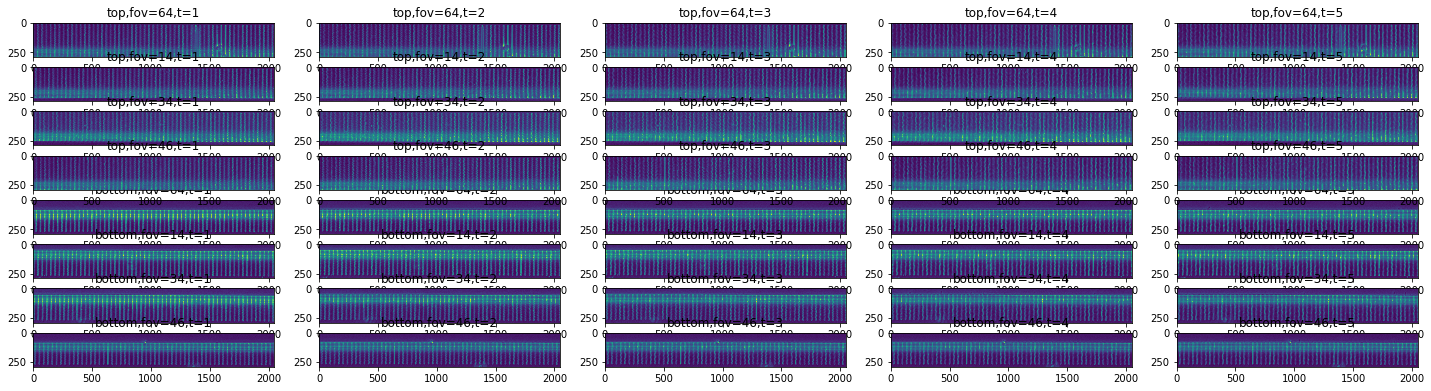

Timer unit: 1e-06 s

Total time: 4.32805 s
File: <ipython-input-4-1ebe84035521>
Function: import_hdf5 at line 173

Line #      Hits         Time  Per Hit   % Time  Line Contents
   173                                               def import_hdf5(self,hdf5_handle,t_dim_in):
   174                                                   """Stripped down version of 'self.chunk_t' that performs initial import of the hdf5 file to be
   175                                                   processed. Simply converts the input hdf5 file's "channel" datasets into the first dimension
   176                                                   of the array, ordered as specified by 'self.all_channels'
   177                                                   
   178                                                   Args:
   179                                                       t_dim_in (int): Specifies the time axis of the input array.
   180                                                       t_dim

In [8]:
%load_ext line_profiler
%lprun -f kymo.import_hdf5 kymo.preview_y_crop([64,14,34,46])

Seems like the limiting factor is by far the initial read in, so it doesn't seem that necessary to use the 8 bit encoding / resizing unless it is done in the primary kymograph code. The pros and cons of including it there are:

#### Pros
 - speedup on all computational operations
 - major speedup on intermediate read/write operations during processing
 
#### Cons
 - computational speedup pretty small
 - would need to compile information about places to crop prior to a final step in which
 cropping actually occurs on the original image data. This is a major restructuring....
 
#### outcome

Just keep this in mind for future features, but for now don't implement. Take interactive mode as is without resizing....

### MAJOR NOTE FOR SEGMENTATION CODE

The conversion to bits can be currupted by outlier signal, possibly from fringing at the end of trenches.

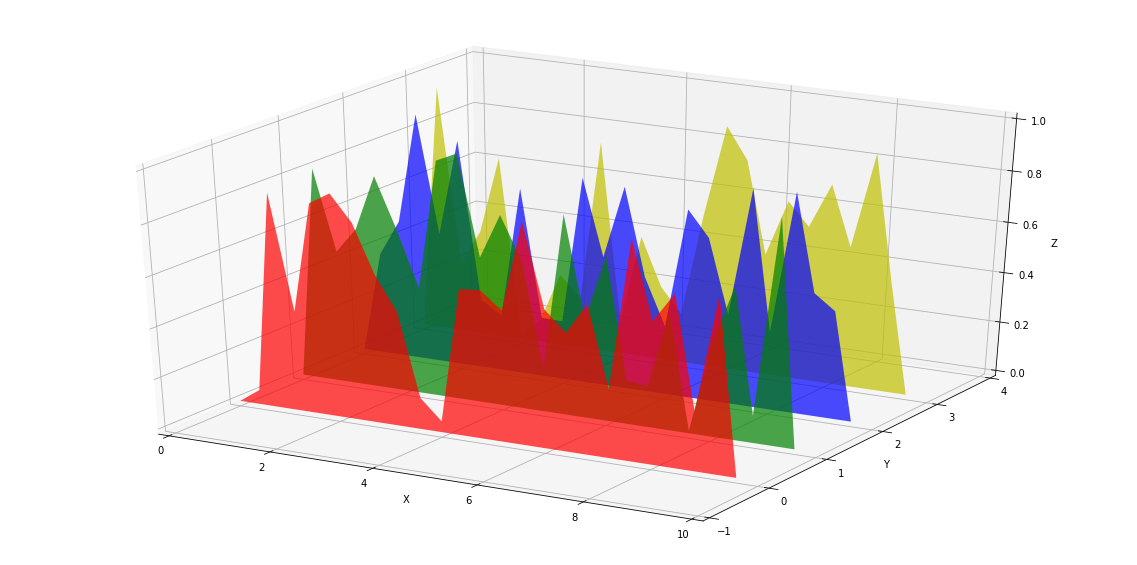

In [224]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

cc = lambda arg: colorConverter.to_rgba(arg, alpha=0.6)

xs = np.arange(0, 10, 0.4)
verts = []
zs = [0.0, 1.0, 2.0, 3.0]
for z in zs:
    ys = np.random.rand(len(xs))
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors = [cc('r'), cc('g'), cc('b'),
                                           cc('y')])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('X')
ax.set_xlim3d(0, 10)
ax.set_ylabel('Y')
ax.set_ylim3d(-1, 4)
ax.set_zlabel('Z')
ax.set_zlim3d(0, 1)

plt.show()

